# $Rayleigh$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

### Fixed parameters


In [2]:
# Constants
num_iter = 10000  # Number of Monte Carlo iterations
N = 2 # No of NOMA users
S = 4096  # Sampled length
a1, a2 = 0.8, 0.2  # Power allocations
Pf = 0.1  # False-alarm probability
env_SNRs_dB = np.arange(
    -25, 6, 1
)  # Range of environmental SNR values to iterate through
transmitter_power = 1

### Lists to store results


In [3]:
Pds = []  # List to store detection probabilities
TPRs_LR = []  # List to store true positive rates
TPRs_RF = []  # List to store true positive rates
TPRs_DT = []  # List to store true positive rates

### Monte Carlo simulation


In [4]:
for env_SNR_dB in env_SNRs_dB:
    # Convert SNR from dB to linear scale
    env_SNR_linear = transmitter_power * 10 ** (env_SNR_dB / 10)

    # Noise standard deviation based on environmental SNR
    N0 = np.sqrt(1 / (2 * env_SNR_linear))

    # Threshold for AND joint user decision
    lambda_AND = (np.sqrt(-np.log(Pf) / (N * S))) * (N0**2)

    # Monte Carlo simulation
    total_transmit = 0
    successful_detection = 0
    false_alarm_count = 0

    F = []

    for _ in range(num_iter):
        # Random cyclic delays
        d1, d2 = np.random.randint(1, S, 2)

        # Complex normal channel coefficients
        h1 = np.random.normal(0, np.sqrt(0.5)) + 1j * np.random.normal(0, np.sqrt(0.5))
        h2 = np.random.normal(0, np.sqrt(0.5)) + 1j * np.random.normal(0, np.sqrt(0.5))

        # 50% chance that BS1 will transmit signal
        transmit = np.random.rand() < 0.5

        if transmit:
            total_transmit += 1

            # Generating signals for user 1 and user 2
            x1_n = np.random.randn(S)
            x2_n = np.random.randn(S)

            # Combining signals to produce t1 and t2
            t1_n = a1 * x1_n + a2 * x2_n
            t2_n = a1 * np.roll(x1_n, d1) + a2 * np.roll(x2_n, d2)

            # Rayleigh distributed complex normal noise
            noise_std_dev = N0 * np.sqrt(1 / 2)
            noise = noise_std_dev * (np.random.randn(S) + 1j * np.random.randn(S))

            # Final sent signal
            r_n = h1 * t1_n + h2 * t2_n + noise

            # Cyclic correlation processing
            F_delta1 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d1)))) / S
            F_delta2 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d2)))) / S

            F.append({"F1": F_delta1, "F2": F_delta2, "transmit": 1})

            # Decision
            if F_delta1 > lambda_AND and F_delta2 > lambda_AND:
                successful_detection += 1

        if not transmit:
            # Generating noise only
            noise_std_dev = N0 * np.sqrt(1 / 2)
            noise = noise_std_dev * (np.random.randn(S) + 1j * np.random.randn(S))
            r_n = noise

            # Cyclic correlation processing
            F_delta1 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d1)))) / S
            F_delta2 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d2)))) / S

            F.append({"F1": F_delta1, "F2": F_delta2, "transmit": 0})

            # Decision
            if F_delta1 > lambda_AND and F_delta2 > lambda_AND:
                false_alarm_count += 1

    # Probability of detection
    Pd = successful_detection / total_transmit if total_transmit > 0 else 0
    Pds.append(Pd)

    # Convert F to DataFrame
    F = pd.DataFrame(F)
    X = F[["F1", "F2"]]
    y = F["transmit"]

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Divide the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y, test_size=0.2, random_state=42
    )

    # Classifier
    clf_lr = LogisticRegression(random_state=42, max_iter=1000)
    clf_rf = RandomForestClassifier(random_state=42)
    clf_dt = DecisionTreeClassifier(random_state=42)

    # Train the Classifier
    clf_lr.fit(X_train, y_train)
    clf_rf.fit(X_train, y_train)
    clf_dt.fit(X_train, y_train)

    # Define the desired FPR
    desired_fpr = 0.1

    # ROC curve plotting
    y_probs_lr = clf_lr.predict_proba(X_test)[:, 1]
    y_probs_rf = clf_rf.predict_proba(X_test)[:, 1]
    y_probs_dt = clf_dt.predict_proba(X_test)[:, 1]

    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_probs_dt)

    # Create an interpolation function using the FPR and TPR values
    interp_tpr_lr = interp1d(fpr_lr, tpr_lr)
    interp_tpr_rf = interp1d(fpr_rf, tpr_rf)
    interp_tpr_dt = interp1d(fpr_dt, tpr_dt)

    # Define a new set of FPR values for the interpolated curve
    new_fpr = np.linspace(0, 1, 1000)

    # Use the interpolation function to find the TPR for the new FPR values
    new_tpr_lr = interp_tpr_lr(new_fpr)
    new_tpr_rf = interp_tpr_rf(new_fpr)
    new_tpr_dt = interp_tpr_dt(new_fpr)

    # TPR at desired FPR
    tpr_lr = interp_tpr_lr(desired_fpr)
    tpr_dt = interp_tpr_dt(desired_fpr)
    tpr_rf = interp_tpr_rf(desired_fpr)

    TPRs_LR.append(tpr_lr)
    TPRs_RF.append(tpr_rf)
    TPRs_DT.append(tpr_dt)

### Convert lists to numpy arrays


In [5]:
Pds = np.array(Pds)
TPRs_LR = np.array(TPRs_LR)

### Plotting Probability of detection vs Environmental SNR


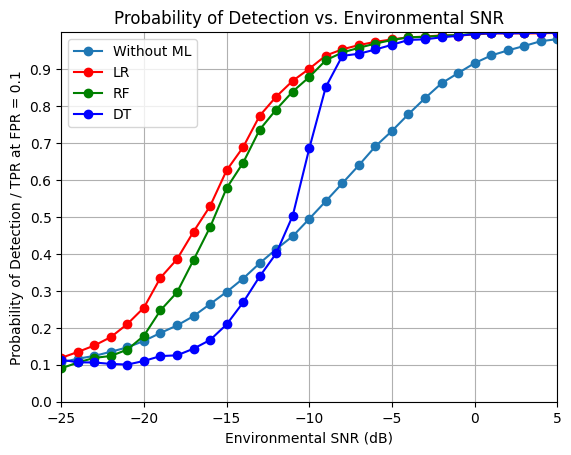

In [6]:
from scipy.signal import savgol_filter

plt.figure()

# Smooth the graph of Pds
Pds_smooth = savgol_filter(Pds, window_length=5, polyorder=3)

TPRs_LR_smooth = savgol_filter(TPRs_LR, window_length=5, polyorder=3)
TPRs_RF_smooth = savgol_filter(TPRs_RF, window_length=5, polyorder=3)
TPRs_DT_smooth = savgol_filter(TPRs_DT, window_length=5, polyorder=3)

plt.yticks(np.arange(0, 1, 0.1))
plt.ylim(0, 1)
plt.xlim(-25, 5)

# Plot the smoothed Probability of Detection vs. Environmental SNR
plt.plot(env_SNRs_dB, Pds_smooth, marker="o", label="Without ML")

plt.plot(env_SNRs_dB, TPRs_LR_smooth, marker="o", color="red", label="LR")
plt.plot(env_SNRs_dB, TPRs_RF_smooth, marker="o", color="green", label="RF")
plt.plot(env_SNRs_dB, TPRs_DT_smooth, marker="o", color="blue", label="DT")


plt.title("Probability of Detection vs. Environmental SNR")
plt.xlabel("Environmental SNR (dB)")
plt.ylabel("Probability of Detection / TPR at FPR = 0.1")
plt.grid(True)
plt.legend()
plt.show()